In [ ]:
import pandas as pd
import mysql.connector
import os


# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments') ,
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Im@sagar7110',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'D:\Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [59]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import mysql.connector
import numpy as np
db =mysql.connector.connect (host="localhost",
                            username ="root",
                            password="Im@sagar7110",
                            database ="ecommerce")

cur=db.cursor()

                

# List all unique cities where customers are located.

In [58]:
query =  """SELECT DISTINCT customer_city FROM customers"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data, columns=["City"])
df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the numbers of orders placed in 2017

In [26]:
query = """SELECT COUNT(order_id) FROM orders WHERE  year(order_purchase_timestamp)=2017 """

cur.execute(query)

data = cur.fetchall()

data

[(45101,)]

# Find the total sales per category

In [37]:
query = """SELECT UPPER(products.product_category) category,
round(sum(payments.payment_value),2) sales
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUp BY category


"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns =["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments

In [45]:
query = """SELECT (SUM(CASE WHEN Payment_installments>=1 then 1 ELSE 0 end))/count(*)*100 FROM payments"""

cur.execute(query)

data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# Count the Number of customers from each state

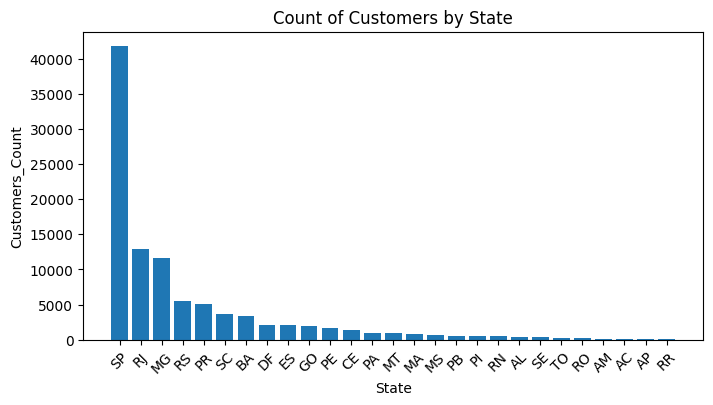

In [75]:
query = """ SELECT customer_state, COUNT(customer_id) FROM customers GROUP BY customer_state """

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns =["State","Customers_Count"])
df= df.sort_values(by ="Customers_Count",ascending=False)
plt.figure(figsize=(8,4))
plt.bar(df["State"],df["Customers_Count"])
plt.xticks(rotation=45)
plt.xlabel("State")
plt.ylabel("Customers_Count")
plt.title("Count of Customers by State")
plt.show()

# Count the Number of Orders per month in 2018

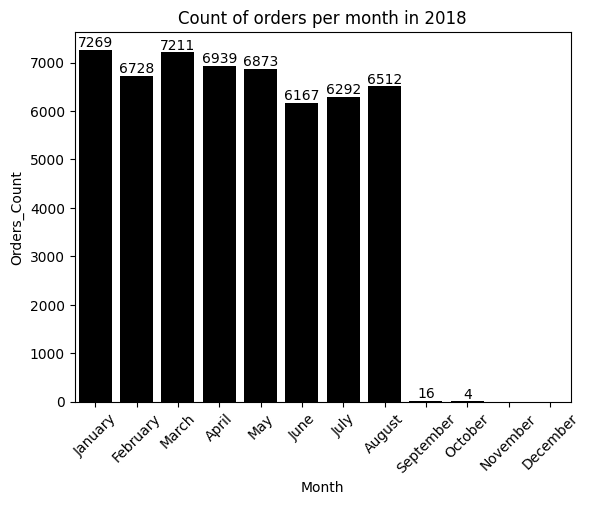

In [34]:
query = """SELECT monthname(order_purchase_timestamp) months , COUNT(order_id) order_count 
FROM orders WHERE year(order_purchase_timestamp)=2018
GROUP BY months
"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data, columns=["Month","Orders_Count"])
o=["January","February","March","April","May","June","July","August","September","October","November","December"]
df= df.sort_values(by ="Month",ascending=True)
ax=sns.barplot(x=df["Month"],y=df["Orders_Count"],data=df, order=o,color="black")
plt.xticks(rotation=45)
plt.title("Count of orders per month in 2018")
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by Customer city.

# Find the average number of products per order, grouped by Customer city.

In [14]:
query = """WITH count_per_order as 
(SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
FROM orders JOIN order_items 
on orders.order_id = order_items.order_id
GROUP BY orders.order_id, orders.customer_id)

SELECT customers.customer_city, ROUND(AVG(count_per_order.oc),2) average_orders
FROM customers JOIN count_per_order
on customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
"""

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data, columns=["City","Avg Orders"])
df

,City,Avg Orders
0,sao paulo,1.16
1,sao jose dos campos,1.14
2,porto alegre,1.17
3,indaial,1.12
4,treze tilias,1.27
...,...,...
4105,buriti,3.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# Calculate the percentage of total revenue contributed by each product category

In [18]:
query = """SELECT UPPER(products.product_category) category,
round((sum(payments.payment_value)/(SELECT SUM(payment_value) FROM payments ))*100,2) sales
FROM products JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUp BY category


"""

cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data, columns =["Category"," Percentage Sales"])
df

,Category,Percentage Sales
0,PERFUMERY,3.17
1,FURNITURE DECORATION,8.93
2,TELEPHONY,3.04
3,BED TABLE BATH,10.70
4,AUTOMOTIVE,5.32
...,...,...
69,CDS MUSIC DVDS,0.01
70,LA CUISINE,0.02
71,FASHION CHILDREN'S CLOTHING,0.00
72,PC GAMER,0.01


# Identify the Correlation between product price and the number of times a product has been purchased

In [16]:
query =""" SELECT products.product_category,
count(order_items.product_id),
ROUND(AVG(order_items.price),2)
FROM products JOIN order_items 
ON products.product_id = order_items.product_id
GROUP BY products.product_category
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns =["Category","Order_Count","Price"])

arr1=df["Order_Count"]
arr2=df["Price"]

a=np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is",a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue 

In [40]:
query =""" SELECT * , dense_rank() over(order by revenue desc) as rn from
(SELECT order_items.seller_id ,ROUND(SUM(payments.payment_value),2) revenue
FROM order_items JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id) as a
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns =["Seller_id","Revenue_Generated","Rank"])
df
#To generate the bar plot 1:25 hrs

,Seller_id,Revenue_Generated,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


# Calculate the moving average order values for each customer for their order history

In [61]:
query ="""SELECT customer_id, order_purchase_timestamp,payment,
AVG(payment) OVER(partition by customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 preceding and current row) as Mov_Avg
FROM
(SELECT orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value as payment
FROM payments join orders 
on payments.order_id = orders.order_id) as a 
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customer_id","order_purchase_timestamp","payment","Mov_Avg"])
df

,Customer_id,order_purchase_timestamp,payment,Mov_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year

In [63]:
query="""SELECT years , months,payment,sum(payment)
OVER(ORDER BY years,months) cumulative_sales from 
(SELECT year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
ROUND(SUM(payments.payment_value),2) as payment FROM orders join payments
on orders.order_id = payments.order_id
GROUP BY years , months ORDER BY years,months ) as a
"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Years","Months","Payment_value","Cumulative_Sales"])
df

,Years,Months,Payment_value,Cumulative_Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate year-over-year growth rate of total sales

In [73]:
query="""
with a as(SELECT year(orders.order_purchase_timestamp) as years,
ROUND(SUM(payments.payment_value),2) as payment FROM orders join payments
on orders.order_id = payments.order_id
GROUP BY years  ORDER BY years)

SELECT years, ((payment - lag(payment,1 ) OVER(ORDER BY years))/
lag(payment,1 ) OVER(ORDER BY years))*100  FROM a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Growth"])
df

,Year,Growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [78]:
query="""with a as(SELECT customers.customer_id,
min(orders.order_purchase_timestamp) first_order 
FROM customers JOIN orders
on customers.customer_id = orders.customer_id
GROUP BY customers.customer_id),


b as (SELECT a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
FROM a JOIN orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
GROUP BY a.customer_id)


SELECT 100 * (COUNT(distinct a.customer_id)/ COUNT(distinct b.customer_id))
FROM a LEFT JOIN b
on a.customer_id = b.customer_id
"""

cur.execute(query)
data=cur.fetchall()
data

# there is no customer retention in 6 months from the previous order purchase timestamp

[(None,)]

# identify the top 3 customers who spend the most money in each year

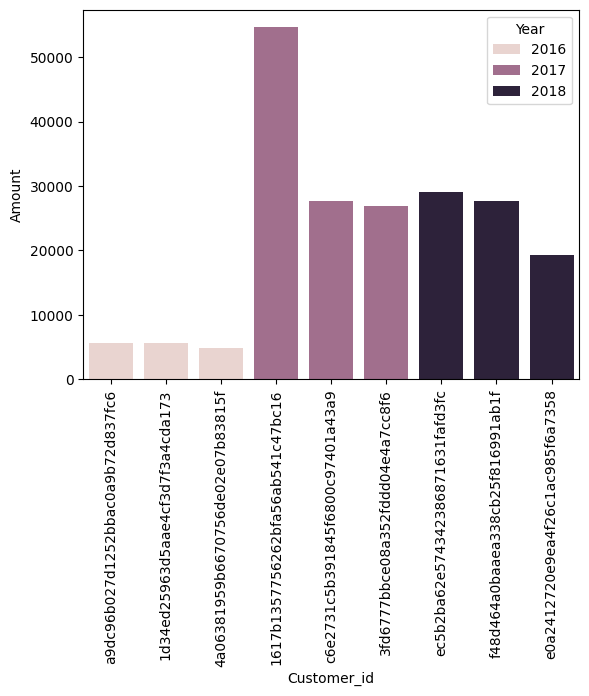

In [87]:
query="""
SELECT years , customer_id ,payment , d_rank
FROM 
(SELECT year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment ,
dense_rank() over(partition by year( orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments

on payments.order_id =orders.order_id 
GROUP BY year(orders.order_purchase_timestamp),
orders.customer_id) as a 
WHERE d_rank <=3
"""


cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["Year","Customer_id","Amount","Rank"])
sns.barplot(x="Customer_id" ,y="Amount" , data=df, hue = "Year")
plt.xticks(rotation=90)
plt.show()